# PyTorch study_third week assignment

### 1. 개념문제 

1.  합성곱 연산도 인공 신경망의 일종이라고 볼 수 있으나, 차이점이 두가지 존재함
    <br> 1-1 하나의 결괏값이 생성될 때 입력값 전체가 들어가지 않고 (   )가 지나가는 부분만 연산에 포함된다는 점
    <br> 1-2 하나의 이미지에 같은 필터를 연달아 적용하기 때문에 가중치가 공유되어 기본 인공 신경망보다 학습의 대상이 되는 변수가 ( 많다/적다)는 점

정답 
<br> 1-1 : 필터
<br> 1-2 : 적다

<br>

2. 합성곱 신경망에서 사용하는 활성화 함수는 렐루 함수가 있습니다. 렐루함수의 대표적인 3가지 함수를 맞춰보세요
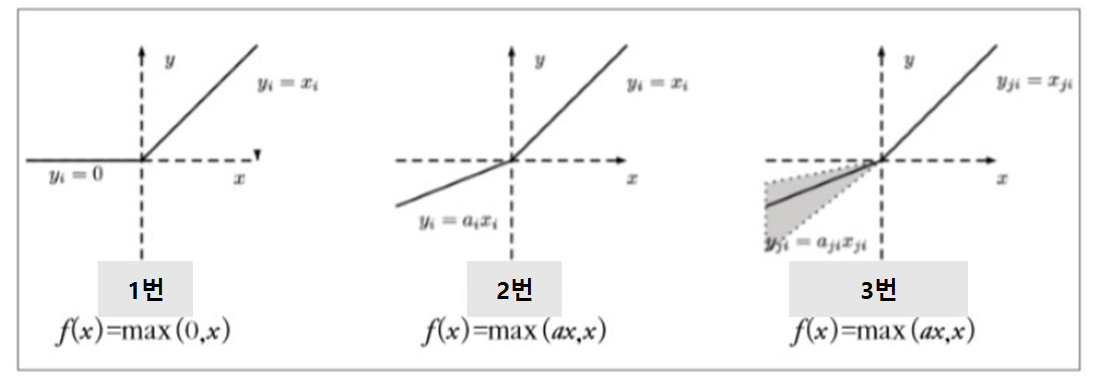

정답 
<br> 2-1 : 렐루함수
<br> 2-2 : 리키 렐루 함수
<br> 2-3 : 랜덤 리키 렐루 함수

3. 패딩과 풀딩
<br> 3-1 합성곱 연산을 사용하되 더 깊은 신경망을 만들기 위해 등장한 것은 ? 
<br> 3-2 합성곱 신경망에서는 크게 두 종류가 사용이 되는데, 첫 번째는 (      ) 으로, 일정 크기의 구간 내에서 가장 큰 값만을 전달하고 다른 정보는 버리는 방법이다. 두 번째는 (   ) 입니다. 이는 일정 크기의 구간 내의 값들의 평균을 전달하는 방법입니다.

정답 
<br> 3-1 : 패딩
<br> 3-2 : 맥스 풀링, 평균 풀링

# 2. 모델 구현 문제

In [1]:
# 필요한 모듈 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset # 데이터를 읽어오는 역할
import torchvision.transforms as transforms # 불러온 이미지를 필요에 따라 변환해주는 역할
from torch.utils.data import DataLoader # 데이터를 배치 사이즈대로 묶어서 전달하거나 정렬, 셔플 등을 해주는 역할

from tqdm.notebook import tqdm

1. 데이터를 하나씩 전달하지 않고 하는 배치사이즈 대로 묶어서 전달하기 위해 barch_size를 256 으로 설정해주세요

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [3]:
# MNIST 데이터셋 불러오기 (datasets, transforms)
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(),
                        target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(),
                        target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


2. Data Loder : train_loader와 test_loder에 batch_size는 앞에서 설정했던 256, 셔플여부는 True로, 데이터를 묶을 때 사용하는 프로세스 개수는 2개로, 묶고 남은 데이터는 버려주세요

In [4]:
# DataLoader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size,
                                          shuffle = True, num_workers = 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size,
                                          shuffle = True, num_workers = 2, drop_last = True)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [6]:
#최적화 함수로 새롭게 Adam 알고리즘을 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
loss_arr = []
for i in tqdm(range(num_epoch)):
    for j,[image,label] in tqdm(enumerate(train_loader)):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(2.3037, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.2147, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.1107, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.1095, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.1037, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)


0it [00:00, ?it/s]

tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)


3. torch.max 함수를 사용해서 최댓값과 그 인덱스를 구하세요

In [8]:
correct = 0
total = 0

with torch.no_grad(): # 기울기를 계산하지 않음
    for image,label in test_loader:
        x = image.to(device)
        y_ = label.to(device)
        
        output = model.forward(x)
        _, output_index =  torch.max(output,1)
        
        total += label.size(0)
        correct += (output_index == y_).sum().float() # 예측 라벨과 실제 라벨이 동일하면 더해줌
        
    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 98.828125
